[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rsarka34/R2REst/blob/main/model/TBCS/R2REst_TBCS_Git.ipynb)

**R2Rest: A Novel Deep Learning Framework for Estimating Respiration Rate from Respiratory Sounds**

**Authors: Soubhagya Ranjan Hota&dagger;, Arka Roy&dagger;, and Udit Satija** (&dagger; means equally contributed in the paper)

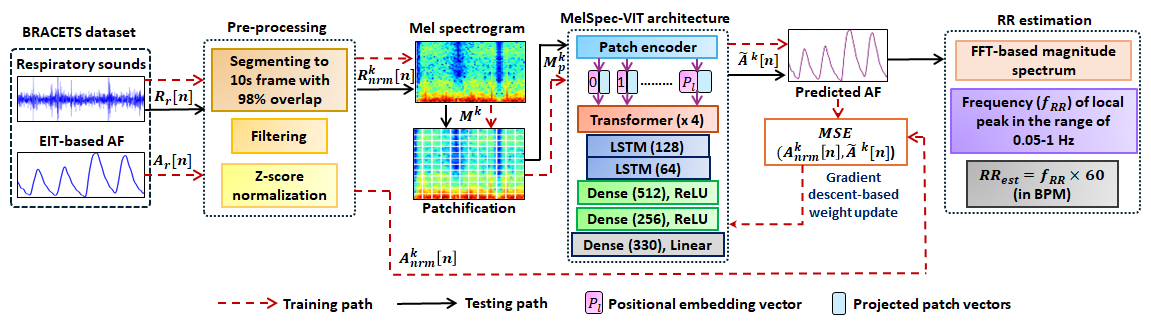


## **LOAD TBCS RESPIRATORY SOUND AND EIT-AF DATA FROM DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!pip install mat73
import mat73
EIT_98_dict=mat73.loadmat('/content/gdrive/MyDrive/ARKA/EIT_work/TbCS/10_sec_data/EIT_tbcs.mat')
EIT_98_sigs=EIT_98_dict['EITs_tbcs']
LS_98_dict=mat73.loadmat('/content/gdrive/MyDrive/ARKA/EIT_work/TbCS/10_sec_data/LSs_tbcs.mat')
LS_98_sigs=LS_98_dict['LSs_tbcs']

### **VISUALIZE THE TEMPORAL SIGNALS**

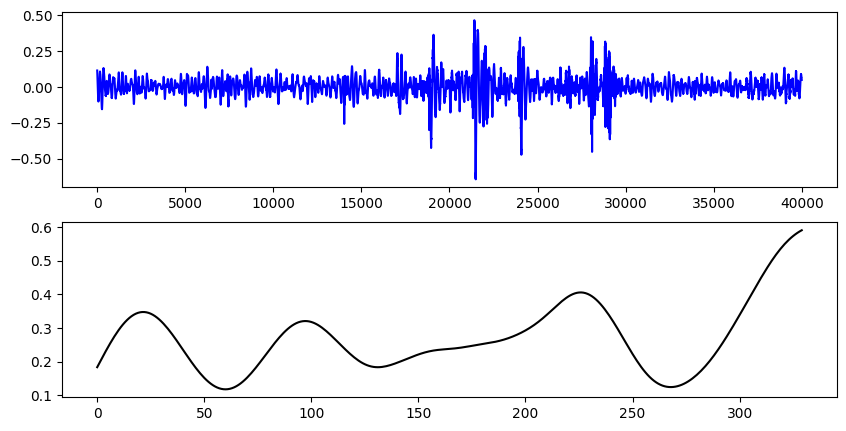

In [ ]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
idx=201; sr=4000;hop_length=len(LS_98_sigs[:,idx])//(64-1);
plt.figure(figsize=(10,5))
plt.subplot(211); plt.plot(LS_98_sigs[:,idx],'b');
plt.subplot(212); plt.plot(EIT_98_sigs[:,idx],'k')

# **MEL SPECTROGRAM GENERATION**

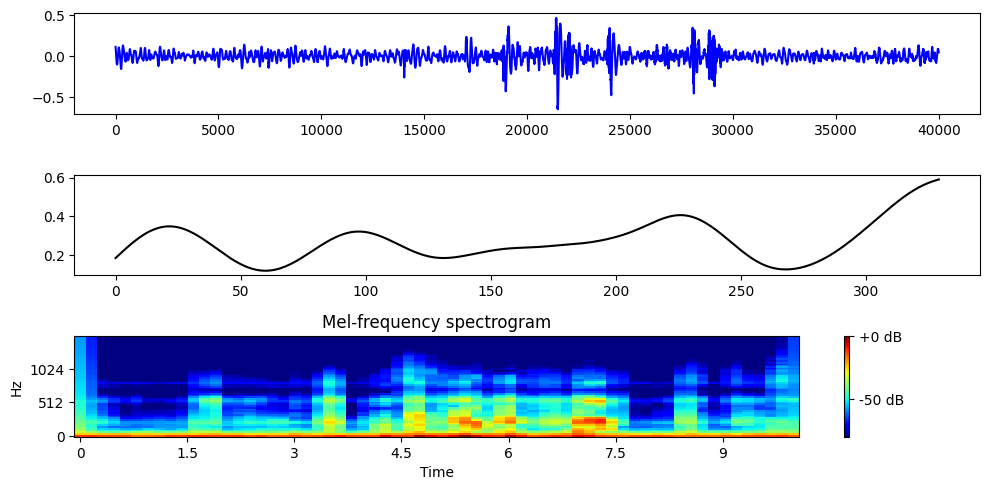

In [ ]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
idx=201; sr=4000;hop_length=len(LS_98_sigs[:,idx])//(64-1);
plt.figure(figsize=(10,5))
plt.subplot(311); plt.plot(LS_98_sigs[:,idx],'b');
plt.subplot(312); plt.plot(EIT_98_sigs[:,idx],'k')
S = librosa.feature.melspectrogram(y=LS_98_sigs[:,idx], sr=4000, n_mels=64,hop_length=hop_length)
S_dB = librosa.power_to_db(S, ref=np.max)
plt.subplot(313);librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,cmap='jet');
librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='jet')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
!pip install opencv-python
import librosa
import matplotlib.pyplot as plt
import numpy as np
r=len(LS_98_sigs[1,:])
nfft=1024
win_length=1024
sr=4000
melspec_list=[];mfcc_list=[]; cqt_list=[];
d_shape=64

# Import cv2 (now opencv-python) without aliasing
import cv2
for i in range (r):
  clip=LS_98_sigs[:,i]
  # melspectrogram
  mel_spec=librosa.feature.melspectrogram(y=clip,sr=4000,n_mels=64,n_fft=1024,hop_length=len(LS_98_sigs[:,i])//(64-1),win_length=1024,window='hann')
  log_melspec = librosa.amplitude_to_db(mel_spec)
  norm_melspec=(log_melspec-np.min(log_melspec))/(np.max(log_melspec)-np.min(log_melspec))
  cmap = plt.get_cmap('jet')
  rgba_img = cmap(norm_melspec)
  rgb_img = np.delete(rgba_img, 3, 2)
  mel_img=np.flip(rgb_img, 0)
  melspec_list.append(mel_img)

melspec_set=np.array(melspec_list)
print('shape of melspectrogram dataset'+str(np.shape(melspec_set)))
import pickle
# Save the Mel spectrogram using pickle
with open('mel_spectrogram.pkl', 'wb') as f:
    pickle.dump(mel_img, f)
print("Mel spectrogram saved to 'mel_spectrogram.pkl'")

shape of melspectrogram dataset(12900, 64, 64, 3)
Mel spectrogram saved to 'mel_spectrogram.pkl'


In [ ]:
import pickle
def pickle_save(location_to_save,dumping_var):
    outfile = open(location_to_save,'wb')
    pickle.dump(dumping_var,outfile)
    outfile.close()
    print('=========done=========')

base_location='/content/gdrive/MyDrive/Soubhagya/VIT/TBCS model/10 sec/'
saving_melspec=base_location+'Melspecs_R2REST_Tbcs_rgb'

pickle_save(saving_melspec,melspec_set)

=========done=========


# **You can directly run from here**

In [ ]:
import pickle
!pip install mat73
import matplotlib.pyplot as plt
import librosa
import numpy as np
import mat73
EIT_98_dict=mat73.loadmat('/content/gdrive/MyDrive/ARKA/EIT_work/TbCS/10_sec_data/EIT_tbcs.mat')
EIT_98_sigs=EIT_98_dict['EITs_tbcs']


def load_pickle_file(name_of_file):
    infile = open(name_of_file,'rb')
    wgt = pickle.load(infile)
    infile.close()
    return wgt

Melspecs= load_pickle_file('/content/gdrive/MyDrive/Soubhagya/VIT/TBCS model/10 sec/Melspecs_R2REST_Tbcs_rgb')
EITs_re = np.expand_dims(EIT_98_sigs.T, axis=-1)

print('shape of melspectrogram dataset'+str(np.shape(Melspecs)))
print('shape of EIT dataset'+str(np.shape(EITs_re)))

shape of melspectrogram dataset(12900, 64, 64, 3)
shape of EIT dataset(12900, 330, 1)


## **DATA SPLITTING FOR TRAINING-VALIDATION-TESTING**

In [ ]:
num_classes = 4
input_shape = (64, 64, 3)

seed=10;
X_train_1,X_test,Y_train_1,Y_test=train_test_split(Melspecs,EITs_re,test_size=0.1,random_state=seed)
X_train,X_val,Y_train,Y_val=train_test_split(X_train_1,Y_train_1,test_size=0.1,random_state=seed)
print('shape of training dataset'+str(np.shape(X_train)))
print('shape of validation dataset'+str(np.shape(X_val)))
print('shape of test dataset'+str(np.shape(X_test)))

shape of training dataset(10449, 64, 64, 3)
shape of validation dataset(1161, 64, 64, 3)
shape of test dataset(1290, 64, 64, 3)


## **SETUP FOR MELSPEC-VIT**

**We have used "TensorFlow==2.15.1". First we have downgraded the tensorflow version and thereby restarted the session and and subsequently imported the downgraded tensorflow!!:)**

In [ ]:
!pip install tensorflow==2.15.1
!pip install tensorflow-addons
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
!pip install -U tensorflow-addons
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Add, Dropout, LSTM, Reshape
from tensorflow import keras

### **HYPERPARAMETERS**

In [ ]:
learning_rate = 0.0001
weight_decay = 0.001
image_size = 64  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 3
mlp_head_units = [330]  # Size of the dense layers of the final classifier

### **PATCHIFICATION**

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### **PLOT OF RANDOM PATCHIFICATION OF A MEL SPECTROGRAM FROM THE TBCS DATA**

Image size: 64 X 64
Patch size: 8 X 8
Patches per image: 64
Elements per patch: 192


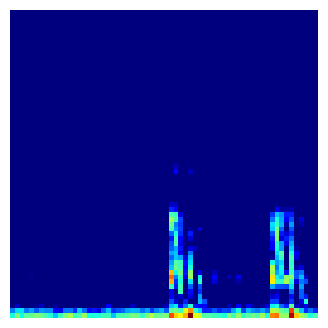

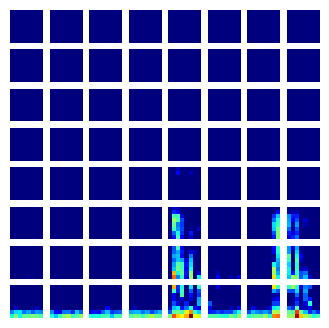

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
EITs_re = np.expand_dims(EIT_98_sigs.T, axis=-1)
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy(),cmap='jet')
    plt.axis("off")

### **MELSPEC-VIT MODEL CONSTRUCTION**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Add, Dropout, LSTM, Reshape
from tensorflow import keras

# Define input shape parameters
input_shape = (64, 64, 3)
patch_size = 8
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
projection_dim = 64
transformer_layers = 4
num_heads = 4
transformer_units = [128, 64]  # Size of the hidden layers in the MLP of the transformer
mlp_head_units = [512, 256]  # Size of the hidden layers in the MLP of the classifier

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.3
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.3)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, num_patches, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

    # Reshape the representation for LSTM input
    reshaped_representation = Reshape((num_patches, projection_dim))(representation)
    x = LSTM(128, return_sequences=True)(reshaped_representation)
    x = LSTM(64)(x)

    # Add MLP.
    features = mlp(x, hidden_units=mlp_head_units, dropout_rate=0.3)

    # Classify outputs.
    output = Dense(330)(features)
    output = Reshape((330, 1))(output)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=output)
    return model

vit_classifier = create_vit_classifier()

vit_classifier.compile(
    optimizer='adam',
    loss='mse'
)

vit_classifier.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 patches_7 (Patches)         (None, None, 192)            0         ['input_2[0][0]']             
                                                                                                  
 patch_encoder_1 (PatchEnco  (None, 64, 64)               16448     ['patches_7[0][0]']           
 der)                                                                                             
                                                                                                  
 layer_normalization_9 (Lay  (None, 64, 64)               128       ['patch_encoder_1[0][0]'

### **Train the model**

In [ ]:
history = vit_classifier.fit(
        X_train,
        Y_train,
        batch_size=128,
        epochs=150,
        validation_data=(X_val, Y_val),

    )

Epoch 1/150
82/82 [==============================] - 39s 333ms/step - loss: 0.0624 - val_loss: 0.0472
Epoch 2/150
82/82 [==============================] - 25s 299ms/step - loss: 0.0493 - val_loss: 0.0474
Epoch 3/150
82/82 [==============================] - 24s 298ms/step - loss: 0.0487 - val_loss: 0.0468
Epoch 4/150
82/82 [==============================] - 24s 298ms/step - loss: 0.0481 - val_loss: 0.0463
Epoch 5/150
82/82 [==============================] - 24s 299ms/step - loss: 0.0462 - val_loss: 0.0432
Epoch 6/150
82/82 [==============================] - 24s 298ms/step - loss: 0.0437 - val_loss: 0.0419
Epoch 7/150
82/82 [==============================] - 25s 299ms/step - loss: 0.0415 - val_loss: 0.0397
Epoch 8/150
82/82 [==============================] - 24s 297ms/step - loss: 0.0399 - val_loss: 0.0387
Epoch 9/150
82/82 [==============================] - 24s 298ms/step - loss: 0.0380 - val_loss: 0.0365
Epoch 10/150
82/82 [==============================] - 24s 298ms/step - loss: 0.036

### **Plot curves**

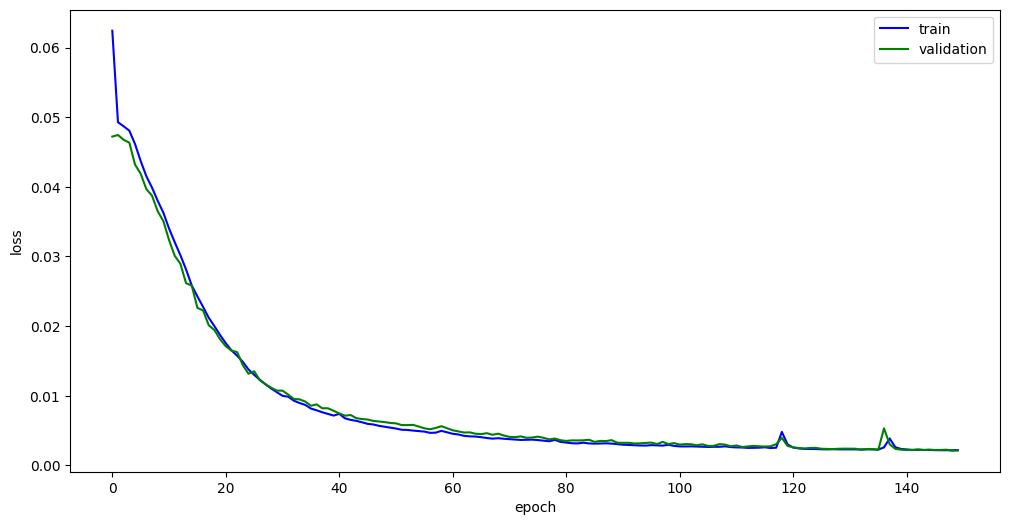

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'g')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation',], loc='best')
plt.show()

### **Prediction**

In [ ]:
predictions = vit_classifier.predict(X_test)
# Print the outputs
print("Output Shape:", predictions.shape)

# import matplotlib.pyplot as plt

# # Plot actual and decoded EIT
# for i in range (predictions.shape[0]):
#     plt.figure(figsize=(10, 5))
#     plt.subplot(121)
#     plt.plot(Y_test[i])
#     plt.title("Actual EIT")
#     plt.subplot(122)
#     plt.plot(predictions[i])
#     plt.title("Predicted EIT")
#     plt.show()

41/41 [==============================] - 3s 46ms/step
Output Shape: (1290, 330, 1)


**SAVE TRAINED MELSPEC-VIT FOR TBCS CASE**

In [ ]:
# Save the model architecture to a JSON file
model_json = vit_classifier.to_json()
with open("/content/gdrive/MyDrive/Soubhagya/VIT/TBCS model/10 sec/VIT_model_R2Rest_Tbcs.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to an HDF5 file
vit_classifier.save_weights("/content/gdrive/MyDrive/Soubhagya/VIT/TBCS model/10 sec/VIT_model_R2Rest_Tbcs_weights.h5")


## **TESTING**

In [ ]:
import numpy as np
from scipy.stats import pearsonr
!pip install tensorflow==2.15.1
!pip install mat73
import mat73
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully un

Shape of melspectrogram dataset: (12900, 64, 64, 3, 1)
Shape of EIT dataset: (12900, 330, 1)
41/41 [==============================] - 3s 47ms/step
Average MAE: 0.03468559718070621
Standard Deviation MAE: 0.019741397372230084
Average MSE: 0.0023684812712072537
Standard Deviation MSE: 0.005883396455576514
Average RMSE: 0.0427586193815849
Standard Deviation RMSE: 0.023241810165905874
Average PCC: 0.9604753778773942
Standard Deviation PCC: 0.0800960756021303


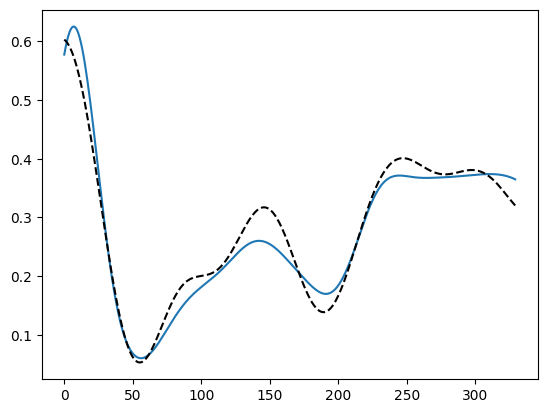

In [ ]:
import numpy as np
import mat73
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define functions to calculate the required metrics
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def pcc(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

def results_gen(Melspec_path, EIT_path, model_path, model_weight_path):
    EIT_98_dict = mat73.loadmat(EIT_path)
    key_dict = list(EIT_98_dict.keys())
    EIT_98_sigs = EIT_98_dict[key_dict[0]]

    import pickle
    def load_pickle_file(name_of_file):
        infile = open(name_of_file, 'rb')
        wgt = pickle.load(infile)
        infile.close()
        return wgt

    Melspecs = load_pickle_file(Melspec_path)
    Melspecs_re = np.expand_dims(Melspecs, axis=-1)
    EITs_re = np.expand_dims(EIT_98_sigs.T, axis=-1)

    print('Shape of melspectrogram dataset:', np.shape(Melspecs_re))
    print('Shape of EIT dataset:', np.shape(EITs_re))

    seed = 10
    X_train1, X_test, Y_train1, Y_test = train_test_split(Melspecs_re, EITs_re, test_size=0.1, random_state=seed)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_train1, Y_train1, test_size=0.1, random_state=seed)

    import tensorflow as tf
    from tensorflow.keras.models import model_from_json
    from tensorflow.keras import layers
    from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Add, Dropout, LSTM, Reshape

    # Define input shape parameters
    input_shape = (64, 64, 3)
    patch_size = 8
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    projection_dim = 64
    transformer_layers = 4
    num_heads = 4
    transformer_units = [128, 64]  # Size of the hidden layers in the MLP of the transformer
    mlp_head_units = [512, 256]  # Size of the hidden layers in the MLP of the classifier

    @tf.keras.utils.register_keras_serializable()
    class Patches(layers.Layer):
        def __init__(self, patch_size):
            super(Patches, self).__init__()
            self.patch_size = patch_size

        def call(self, images):
            batch_size = tf.shape(images)[0]
            patches = tf.image.extract_patches(
                images=images,
                sizes=[1, self.patch_size, self.patch_size, 1],
                strides=[1, self.patch_size, self.patch_size, 1],
                rates=[1, 1, 1, 1],
                padding='VALID',
            )
            patch_dims = patches.shape[-1]
            patches = tf.reshape(patches, [batch_size, -1, patch_dims])
            return patches

    @tf.keras.utils.register_keras_serializable()
    class PatchEncoder(layers.Layer):
        def __init__(self, num_patches, projection_dim):
            super(PatchEncoder, self).__init__()
            self.num_patches = num_patches
            self.projection = layers.Dense(units=projection_dim)
            self.position_embedding = layers.Embedding(
                input_dim=num_patches, output_dim=projection_dim
            )

        def call(self, patch):
            positions = tf.range(start=0, limit=self.num_patches, delta=1)
            encoded = self.projection(patch) + self.position_embedding(positions)
            return encoded

    def mlp(x, hidden_units, dropout_rate):
        for units in hidden_units:
            x = Dense(units, activation=tf.nn.gelu)(x)
            x = Dropout(dropout_rate)(x)
        return x

    def create_vit_classifier():
        inputs = layers.Input(shape=input_shape)
        # Create patches.
        patches = Patches(patch_size)(inputs)
        # Encode patches.
        encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

        # Create multiple layers of the Transformer block.
        for _ in range(transformer_layers):
            # Layer normalization 1.
            x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.3
            )(x1, x1)
            # Skip connection 1.
            x2 = layers.Add()([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP.
            x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.3)
            # Skip connection 2.
            encoded_patches = layers.Add()([x3, x2])

        # Create a [batch_size, num_patches, projection_dim] tensor.
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Reshape the representation for LSTM input
        reshaped_representation = Reshape((num_patches, projection_dim))(representation)
        x = LSTM(128, return_sequences=True)(reshaped_representation)
        x = LSTM(64)(x)

        # Add MLP.
        features = mlp(x, hidden_units=mlp_head_units, dropout_rate=0.3)

        # Classify outputs.
        output = Dense(330)(features)
        output = Reshape((330, 1))(output)

        # Create the Keras model.
        model = tf.keras.Model(inputs=inputs, outputs=output)

        return model

    EIT_model = create_vit_classifier()

    EIT_model.compile(
        optimizer='adam',
        loss='mse'
    )

    # Load json
    json_file = open(model_path, 'r')
    EIT_model_json = json_file.read()
    json_file.close()

    # Register custom objects
    custom_objects = {
        'Patches': Patches,
        'PatchEncoder': PatchEncoder
    }

    # Load model
    EIT_model = model_from_json(EIT_model_json, custom_objects=custom_objects)
    EIT_model.load_weights(model_weight_path)

    predictions = EIT_model.predict(X_test)

    mae_list = []
    mse_list = []
    rmse_list = []
    pcc_list = []

    # Lists to store all y_true and y_pred values
    all_y_true = []
    all_y_pred = []

    for i in range(predictions.shape[0]):
        y_true = Y_test[i].flatten()
        y_pred = predictions[i].flatten()

        # Save y_true and y_pred for this iteration
        all_y_true.append(y_true)
        all_y_pred.append(y_pred)

        mae_list.append(mae(y_true, y_pred))
        mse_list.append(mse(y_true, y_pred))
        rmse_list.append(rmse(y_true, y_pred))
        pcc_list.append(pcc(y_true, y_pred))

        '''for i in range(len(X_test)):
            plt.figure(figsize=(10, 5))
            plt.subplot(121)
            plt.plot(Y_test[i])
            plt.title("Actual EIT")
            plt.subplot(122)
            plt.plot(predictions[i])
            plt.title("Predicted EIT")
            plt.suptitle(f'Iteration => {i}', fontsize=16)
            plt.show()'''

    # Save all y_true and y_pred to text files
    #np.savetxt('/content/gdrive/MyDrive/EIT_SOUBHAGYA/VIT/TbCs_10sec_y_true.txt', np.array(all_y_true))
    #np.savetxt('/content/gdrive/MyDrive/EIT_SOUBHAGYA/VIT/Tbcs_10sec_y_predict.txt', np.array(all_y_pred))

    mae_avg = np.mean(mae_list)
    mse_avg = np.mean(mse_list)
    rmse_avg = np.mean(rmse_list)
    pcc_avg = np.mean(pcc_list)

    std_mae = np.std(mae_list)
    std_mse = np.std(mse_list)
    std_rmse = np.std(rmse_list)
    std_pcc = np.std(pcc_list)

    print(f"Average MAE: {mae_avg}")
    print(f"Standard Deviation MAE: {std_mae}")

    print(f"Average MSE: {mse_avg}")
    print(f"Standard Deviation MSE: {std_mse}")

    print(f"Average RMSE: {rmse_avg}")
    print(f"Standard Deviation RMSE: {std_rmse}")

    print(f"Average PCC: {pcc_avg}")
    print(f"Standard Deviation PCC: {std_pcc}")

    pred_sqz = np.squeeze(predictions, axis=-1)
    true = np.squeeze(Y_test, axis=-1)

    plt.plot(true[1, :])
    plt.plot(pred_sqz[1, :], 'k--')
    plt.show()

# Paths to your files
Melspec_path = '/content/gdrive/MyDrive/Soubhagya/VIT/TBCS model/10 sec/Melspecs_R2REST_Tbcs_rgb'
EIT_path = '/content/gdrive/MyDrive/ARKA/EIT_work/TbCS/10_sec_data/EIT_tbcs.mat'
model_path = '/content/gdrive/MyDrive/Soubhagya/VIT/TBCS model/10 sec/VIT_model_R2Rest_Tbcs.json'
model_weight_path = "/content/gdrive/MyDrive/Soubhagya/VIT/TBCS model/10 sec/VIT_model_R2Rest_Tbcs_weights.h5"
results_gen(Melspec_path, EIT_path, model_path, model_weight_path)


# **RESPIRATORY PARAMETER ESTIMATION:**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install tensorflow==2.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uni

In [1]:
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Add, Dropout, LSTM, Reshape
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
!pip install mat73
import mat73
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import pearsonr


def Get_EIT(Melspec_path, EIT_path, model_path, model_weight_path):
    EIT_98_dict = mat73.loadmat(EIT_path)
    key_dict = list(EIT_98_dict.keys())
    EIT_98_sigs = EIT_98_dict[key_dict[0]]
    import pickle
    def load_pickle_file(name_of_file):
        infile = open(name_of_file, 'rb')
        wgt = pickle.load(infile)
        infile.close()
        return wgt

    Melspecs = load_pickle_file(Melspec_path)
    Melspecs_re = np.expand_dims(Melspecs, axis=-1)
    EITs_re = np.expand_dims(EIT_98_sigs.T, axis=-1)

    print('Shape of melspectrogram dataset:', np.shape(Melspecs_re))
    print('Shape of EIT dataset:', np.shape(EITs_re))

    seed = 10
    X_train1, X_test, Y_train1, Y_test = train_test_split(Melspecs_re, EITs_re, test_size=0.1, random_state=seed)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_train1, Y_train1, test_size=0.1, random_state=seed)


    # Define input shape parameters
    input_shape = (64, 64, 3)
    patch_size = 8
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    projection_dim = 64
    transformer_layers = 4
    num_heads = 4
    transformer_units = [128, 64]  # Size of the hidden layers in the MLP of the transformer
    mlp_head_units = [512, 256]  # Size of the hidden layers in the MLP of the classifier

    @tf.keras.utils.register_keras_serializable()
    class Patches(layers.Layer):
        def __init__(self, patch_size):
            super(Patches, self).__init__()
            self.patch_size = patch_size

        def call(self, images):
            batch_size = tf.shape(images)[0]
            patches = tf.image.extract_patches(
                images=images,
                sizes=[1, self.patch_size, self.patch_size, 1],
                strides=[1, self.patch_size, self.patch_size, 1],
                rates=[1, 1, 1, 1],
                padding='VALID',
            )
            patch_dims = patches.shape[-1]
            patches = tf.reshape(patches, [batch_size, -1, patch_dims])
            return patches

    @tf.keras.utils.register_keras_serializable()
    class PatchEncoder(layers.Layer):
        def __init__(self, num_patches, projection_dim):
            super(PatchEncoder, self).__init__()
            self.num_patches = num_patches
            self.projection = layers.Dense(units=projection_dim)
            self.position_embedding = layers.Embedding(
                input_dim=num_patches, output_dim=projection_dim
            )

        def call(self, patch):
            positions = tf.range(start=0, limit=self.num_patches, delta=1)
            encoded = self.projection(patch) + self.position_embedding(positions)
            return encoded

    def mlp(x, hidden_units, dropout_rate):
        for units in hidden_units:
            x = Dense(units, activation=tf.nn.gelu)(x)
            x = Dropout(dropout_rate)(x)
        return x

    def create_vit_classifier():
        inputs = layers.Input(shape=input_shape)
        # Create patches.
        patches = Patches(patch_size)(inputs)
        # Encode patches.
        encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

        # Create multiple layers of the Transformer block.
        for _ in range(transformer_layers):
            # Layer normalization 1.
            x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.3
            )(x1, x1)
            # Skip connection 1.
            x2 = layers.Add()([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP.
            x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.3)
            # Skip connection 2.
            encoded_patches = layers.Add()([x3, x2])

        # Create a [batch_size, num_patches, projection_dim] tensor.
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Reshape the representation for LSTM input
        reshaped_representation = Reshape((num_patches, projection_dim))(representation)
        x = LSTM(128, return_sequences=True)(reshaped_representation)
        x = LSTM(64)(x)

        # Add MLP.
        features = mlp(x, hidden_units=mlp_head_units, dropout_rate=0.3)

        # Classify outputs.
        output = Dense(330)(features)
        output = Reshape((330, 1))(output)

        # Create the Keras model.
        model = tf.keras.Model(inputs=inputs, outputs=output)

        return model

    EIT_model = create_vit_classifier()

    EIT_model.compile(
        optimizer='adam',
        loss='mse'
    )

    # Load json
    json_file = open(model_path, 'r')
    EIT_model_json = json_file.read()
    json_file.close()

    # Register custom objects
    custom_objects = {
        'Patches': Patches,
        'PatchEncoder': PatchEncoder
    }

    # Load model
    EIT_model = model_from_json(EIT_model_json, custom_objects=custom_objects)
    EIT_model.load_weights(model_weight_path)

    predictions = EIT_model.predict(X_test)
    predictions = np.squeeze(predictions, axis=-1)
    Y_test = np.squeeze(Y_test, axis=-1)
    return Y_test, predictions

import numpy as np
def edge_modify_peak_valley2(samples, t_eit, teit_pk_locs, teit_vl_locs, vl_locs, pk_locs, filt_mr_eit, peaks, valleys):
    # Convert inputs to numpy arrays
    samples = np.array(samples)
    t_eit = np.array(t_eit)
    teit_pk_locs = np.array(teit_pk_locs)
    teit_vl_locs = np.array(teit_vl_locs)
    vl_locs = np.array(vl_locs)
    pk_locs = np.array(pk_locs)
    filt_mr_eit = np.array(filt_mr_eit)
    peaks = np.array(peaks)
    valleys = np.array(valleys)

    # Initialize output variables
    mod_pk_locs = np.copy(pk_locs)
    mod_vl_locs = np.copy(vl_locs)
    mod_peaks = np.copy(peaks)
    mod_valleys = np.copy(valleys)
    teit_mod_pks = np.copy(teit_pk_locs)
    teit_mod_vls = np.copy(teit_vl_locs)

    thr = 18

    # Check the starting point
    if vl_locs[0] and pk_locs[0] == samples[0]:
        pass
    elif vl_locs[0] < pk_locs[0]:
        if (vl_locs[0] - samples[0]) >= thr:
            mod_peaks = np.insert(mod_peaks, 0, filt_mr_eit[0])
            mod_pk_locs = np.insert(mod_pk_locs, 0, samples[0])
            teit_mod_pks = np.insert(teit_mod_pks, 0, t_eit[0])
        else:
            mod_valleys = np.delete(mod_valleys, 0)
            mod_vl_locs = np.delete(mod_vl_locs, 0)
            teit_mod_vls = np.delete(teit_mod_vls, 0)
            mod_vl_locs = np.insert(mod_vl_locs, 0, samples[0])
            teit_mod_vls = np.insert(teit_mod_vls, 0, t_eit[0])
            mod_valleys = np.insert(mod_valleys, 0, filt_mr_eit[0])
    elif vl_locs[0] > pk_locs[0]:
        if (pk_locs[0] - samples[0]) >= thr:
            mod_valleys = np.insert(mod_valleys, 0, filt_mr_eit[0])
            mod_vl_locs = np.insert(mod_vl_locs, 0, samples[0])
            teit_mod_vls = np.insert(teit_mod_vls, 0, t_eit[0])
        else:
            mod_peaks = np.delete(mod_peaks, 0)
            mod_pk_locs = np.delete(mod_pk_locs, 0)
            teit_mod_pks = np.delete(teit_mod_pks, 0)
            mod_pk_locs = np.insert(mod_pk_locs, 0, samples[0])
            teit_mod_pks = np.insert(teit_mod_pks, 0, t_eit[0])
            mod_peaks = np.insert(mod_peaks, 0, filt_mr_eit[0])

    # Check the end point
    if vl_locs[-1] and pk_locs[-1] == samples[-1]:
        pass
    elif vl_locs[-1] > pk_locs[-1]:
        if (samples[-1] - vl_locs[-1]) >= thr:
            mod_peaks = np.append(mod_peaks, filt_mr_eit[-1])
            mod_pk_locs = np.append(mod_pk_locs, samples[-1])
            teit_mod_pks = np.append(teit_mod_pks, t_eit[-1])
        else:
            mod_valleys = np.delete(mod_valleys, -1)
            mod_vl_locs = np.delete(mod_vl_locs, -1)
            teit_mod_vls = np.delete(teit_mod_vls, -1)
            mod_valleys = np.append(mod_valleys, filt_mr_eit[-1])
            mod_vl_locs = np.append(mod_vl_locs, samples[-1])
            teit_mod_vls = np.append(teit_mod_vls, t_eit[-1])
    elif vl_locs[-1] < pk_locs[-1]:
        if (samples[-1] - pk_locs[-1]) >= thr:
            mod_valleys = np.append(mod_valleys, filt_mr_eit[-1])
            mod_vl_locs = np.append(mod_vl_locs, samples[-1])
            teit_mod_vls = np.append(teit_mod_vls, t_eit[-1])
        else:
            mod_peaks = np.delete(mod_peaks, -1)
            mod_pk_locs = np.delete(mod_pk_locs, -1)
            teit_mod_pks = np.delete(teit_mod_pks, -1)
            mod_peaks = np.append(mod_peaks, filt_mr_eit[-1])
            mod_pk_locs = np.append(mod_pk_locs, samples[-1])
            teit_mod_pks = np.append(teit_mod_pks, t_eit[-1])

    return mod_pk_locs, teit_mod_pks, mod_peaks, mod_vl_locs, teit_mod_vls, mod_valleys


def delete_anomalous_extrema(mod_pk_locs, mod_vl_locs, mod_peaks, mod_valleys,samples):
    # Convert inputs to numpy arrays
    mod_pk_locs = np.array(mod_pk_locs)
    mod_vl_locs = np.array(mod_vl_locs)
    mod_peaks = np.array(mod_peaks)
    mod_valleys = np.array(mod_valleys)

    num_peaks = len(mod_pk_locs)
    num_valleys = len(mod_vl_locs)
    thr = 11

    # Calculate the absolute differences for all possible cases between the peak and valley location
    abs_diffs = np.abs(mod_pk_locs[:, np.newaxis] - mod_vl_locs[np.newaxis, :])

    # Find the indices where the distance values are less than the threshold value
    rows, cols = np.where(abs_diffs <= thr)
    unique_rows = np.unique(rows)
    unique_cols = np.unique(cols)

    # Delete those peak and valley locations which have distance less than threshold
    # except if these locations are the extremes of edges (start or end point extrema)
    for r in reversed(unique_rows):
        if mod_pk_locs[r] != samples[0] and mod_pk_locs[r] != samples[-1]:
            mod_pk_locs = np.delete(mod_pk_locs, r)
            mod_peaks = np.delete(mod_peaks, r)

    for c in reversed(unique_cols):
        if mod_vl_locs[c] != samples[0] and mod_vl_locs[c] != samples[-1]:
            mod_vl_locs = np.delete(mod_vl_locs, c)
            mod_valleys = np.delete(mod_valleys, c)

    # Return the final results
    final_pk_locs = mod_pk_locs
    final_vl_locs = mod_vl_locs
    final_peaks = mod_peaks
    final_valleys = mod_valleys

    return final_pk_locs, final_vl_locs, final_peaks, final_valleys

def inspiration_musk_ls(ls_sig, t_ls, sample_ls, t_eit, teit_mod_pks, teit_mod_vls):
    if final_teit_mod_vls[0] < final_teit_mod_pks[0]:
        current_state = 0  # Valley
    else:
        current_state = 1  # Peak

    samp_ls_pks = np.zeros(len(final_teit_mod_pks), dtype=int)
    samp_ls_vls = np.zeros(len(final_teit_mod_vls), dtype=int)

    for i in range(len(final_teit_mod_pks)):
        if final_teit_mod_pks[i] == t_eit[0]:
            samp_ls_pks[i] = sample_ls[0]
        elif final_teit_mod_pks[i] == t_eit[-1]:
            samp_ls_pks[i] = sample_ls[-1]
        else:
            samp_ls_pks[i] = np.argmin(np.abs(t_ls - final_teit_mod_pks[i]))

    for i in range(len(final_teit_mod_vls)):
        if final_teit_mod_vls[i] == t_eit[0]:
            samp_ls_vls[i] = sample_ls[0]
        elif final_teit_mod_vls[i] == t_eit[-1]:
            samp_ls_vls[i] = sample_ls[-1]
        else:
            samp_ls_vls[i] = np.argmin(np.abs(t_ls - final_teit_mod_vls[i]))

    # Initialize the mask array
    Insp_mask_ls = np.zeros(len(ls_sig), dtype=int)
    if current_state == 1:
        Insp_mask_ls[:] = 1
        for j in range(min(len(samp_ls_pks), len(samp_ls_vls))):
            xpk = samp_ls_pks[j]
            xvl = samp_ls_vls[j]
            # Ensure indices are within bounds
            if xpk < len(Insp_mask_ls) and xvl < len(Insp_mask_ls):
                Insp_mask_ls[xpk:xvl+1] = 0
    else:
        for j in range(min(len(samp_ls_pks), len(samp_ls_vls))):
            xpk = samp_ls_pks[j]
            xvl = samp_ls_vls[j]
            # Ensure indices are within bounds
            if xpk < len(Insp_mask_ls) and xvl < len(Insp_mask_ls):
                Insp_mask_ls[xvl:xpk+1] = 1


    return Insp_mask_ls

def inspiration_mask_eit(filt_mr_eit, mod_vl_locs, mod_pk_locs):
    # Determine the initial state
    if mod_vl_locs[0] < mod_pk_locs[0]:
        current_state = 0  # Valley
    else:
        current_state = 1  # Peak

    # Initialize the mask based on the current state
    if current_state == 1:
        Inspiration_musk = np.ones(len(filt_mr_eit), dtype=int)
        for j in range(min(len(mod_pk_locs), len(mod_vl_locs))):
            xpk = mod_pk_locs[j]
            xvl = mod_vl_locs[j]
            Inspiration_musk[xpk:xvl+1] = 0
    else:
        Inspiration_musk = np.zeros(len(filt_mr_eit), dtype=int)
        for j in range(min(len(mod_pk_locs), len(mod_vl_locs))):
            xpk = mod_pk_locs[j]
            xvl = mod_vl_locs[j]
            Inspiration_musk[xvl:xpk + 1] = 1

    return Inspiration_musk

## **TBDB CASE FOR RESPIRATORY PARAMETER ESTIMATION**

In [2]:
Melspec_path = '/content/gdrive/MyDrive/R2REst/Melspecs_R2REST_Tbcs_rgb'
EIT_path = '/content/gdrive/MyDrive/R2REst/EIT_tbcs.mat'

model_path = '/content/gdrive/MyDrive/R2REst/TBCS_10sec_model/VIT_model_10SEC_TBCS.json'
model_weight_path = "/content/gdrive/MyDrive/R2REst/TBCS_10sec_model/VIT_model_10SEC_TBCS_weights.h5"

True_EIT, Pred_EIT = Get_EIT(Melspec_path, EIT_path, model_path, model_weight_path)

print('True EIT shape==>'+str(np.shape(True_EIT)))
print('Predicted EIT shape==>'+str(np.shape(Pred_EIT)))

Shape of melspectrogram dataset: (12900, 64, 64, 3, 1)
Shape of EIT dataset: (12900, 330, 1)
41/41 [==============================] - 11s 167ms/step
True EIT shape==>(1290, 330)
Predicted EIT shape==>(1290, 330)


### **TIDAL VOLUME & EXPIRATION FLOW RATE**

Follow this paper:

**K Haris et al.(2021) "Identification and analysis of stable breathing periods in electrical impedance tomography recordings", Physiol. Meas. 42 064003**

**Link:** ***https://iopscience.iop.org/article/10.1088/1361-6579/ac08e5***

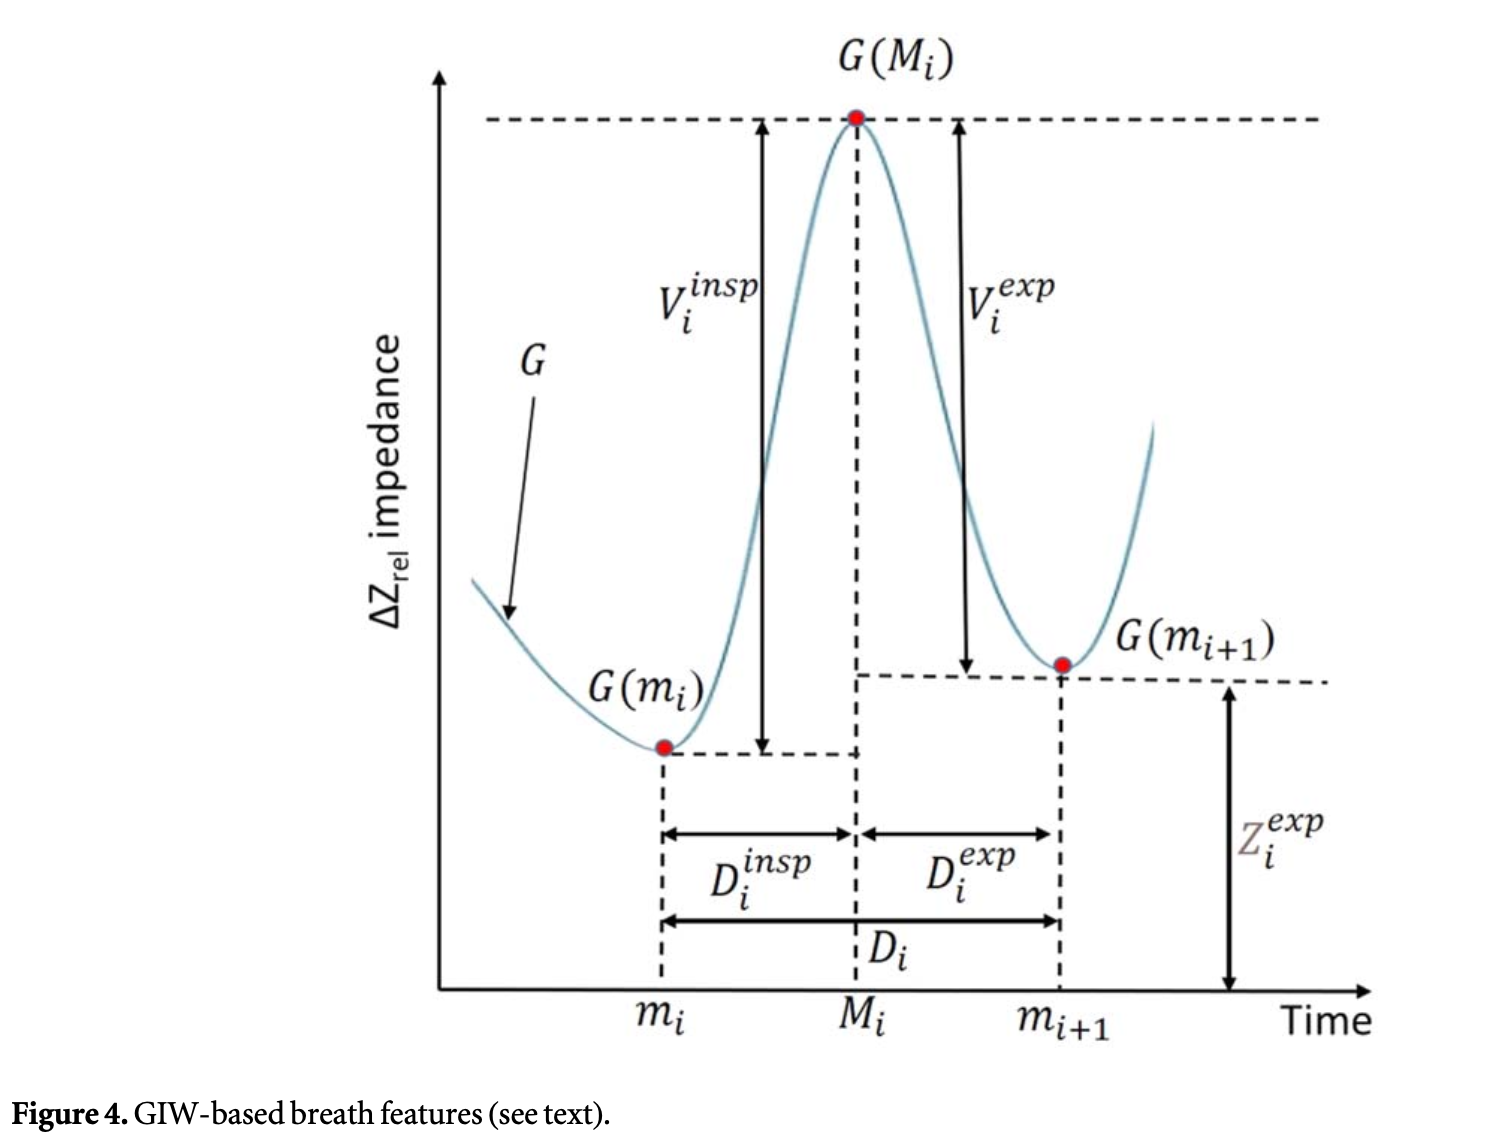

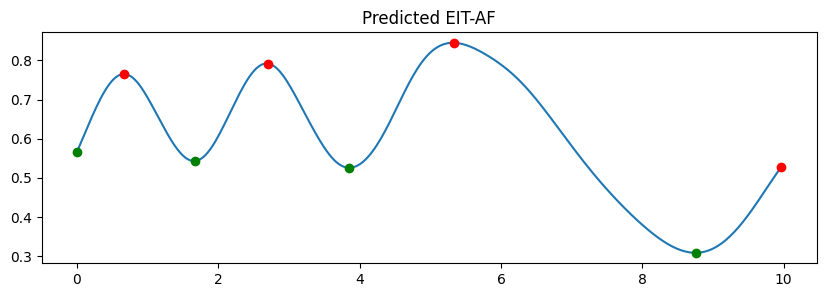

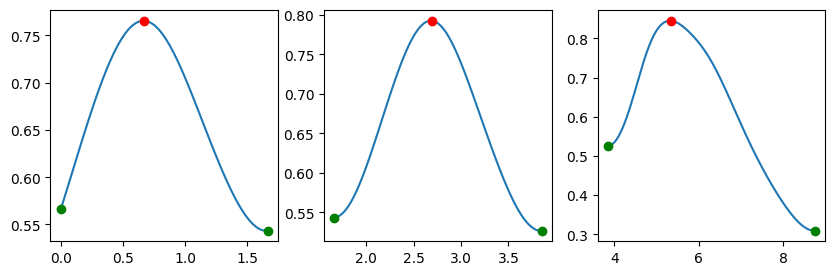

In [3]:
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
i=100;

samples_EIT=np.arange(0,330);
t_eit = np.arange(0, 10, 1/33);

# Predicted eit signal
eit_sig = True_EIT[i]

plt.figure(figsize=(10,3))
plt.plot(t_eit, eit_sig)

# for local maxima
pks_loc = np.array(argrelextrema(eit_sig, np.greater)); pks_locs=pks_loc.reshape(pks_loc.shape[1],)
peaks = eit_sig[pks_locs]; teit_pk_locs = t_eit[pks_locs];
# for local minima
vls_loc = np.array(argrelextrema(eit_sig, np.less)); vls_locs=vls_loc.reshape(vls_loc.shape[1],)
valleys = eit_sig[vls_locs]; teit_vl_locs = t_eit[vls_locs];
# modify edge extrema
mod_pk_locs, teit_mod_pks, mod_peaks, mod_vl_locs, teit_mod_vls, mod_valleys = edge_modify_peak_valley2(samples_EIT, t_eit, teit_pk_locs, teit_vl_locs, vls_locs, pks_locs, eit_sig, peaks, valleys)
# delete anomolus extemas
final_pk_locs, final_vl_locs, final_peaks, final_valleys=delete_anomalous_extrema(mod_pk_locs,mod_vl_locs,mod_peaks,mod_valleys, samples_EIT);
final_teit_mod_pks=t_eit[final_pk_locs]; final_teit_mod_vls=t_eit[final_vl_locs]

plt.plot(final_teit_mod_pks, final_peaks, "ro")
plt.plot(final_teit_mod_vls, final_valleys, "go")
plt.title('Predicted EIT-AF')
plt.show()

# stable breath cycle detection
complete_beats = []
TV_tbdb=[]; PEFR_tbdb=[];
plt.figure(figsize=(10,3))
for i in range(len(final_vl_locs) - 1):
    # extrcat stable phase (amplitude values)
    start_eit = final_vl_locs[i];
    end_eit = final_vl_locs[i + 1];
    beat_eit = eit_sig[start_eit:end_eit];

    # time, index and amplitude of G(mi)
    G_mi=beat_eit[0];
    t_Gmi= final_teit_mod_vls[i];
    loc_tGmi=final_vl_locs[i]

    # time, index and amplitude of G(mi1)
    G_mi1=beat_eit[-1];
    t_Gmi1= final_teit_mod_vls[i + 1];
    loc_tGmi1=final_vl_locs[i + 1]

    # time interval of beats
    beat_t= t_eit[loc_tGmi:loc_tGmi1];

    # find common peak within the extrcated stable breath
    G_Mi = np.intersect1d(final_peaks, beat_eit);
    loc_GMi = np.where(eit_sig==G_Mi)[0][0]
    t_GMi=t_eit[loc_GMi]

    # TV
    V_insp=np.abs(G_Mi-G_mi);
    V_exp=np.abs(G_Mi-G_mi1);
    TV_val=np.max([V_insp[0],V_exp[0]])

    # PEFR
    t_exp=t_Gmi1-t_GMi
    PEFR_val=V_exp/t_exp

    complete_beats.append(beat_eit)
    TV_tbdb.append(TV_val)
    PEFR_tbdb.append(PEFR_val)

    plt.subplot(1,3,i+1)
    plt.plot(beat_t,beat_eit);
    plt.plot(t_Gmi,G_mi, "go"); plt.plot(t_Gmi1,G_mi1, "go")
    plt.plot(t_GMi,G_Mi, "ro");


In [4]:
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import argrelextrema

import warnings
warnings.simplefilter("error")

def Get_respiratory_parameters(EIT):
    samples_EIT=np.arange(0,330);
    t_eit = np.arange(0, 10, 1/33);
    TV_tbcs=[]; PEFR_tbcs=[];

    for j in range(1,len(EIT)):

        try: # Move the try block outside of the inner loop to handle exceptions during each iteration of the outer loop
            # Predicted eit signal
            eit_sig = EIT[j]
            # for local maxima
            pks_loc = np.array(argrelextrema(eit_sig, np.greater)); pks_locs=pks_loc.reshape(pks_loc.shape[1],)
            peaks = eit_sig[pks_locs]; teit_pk_locs = t_eit[pks_locs];
            # for local minima
            vls_loc = np.array(argrelextrema(eit_sig, np.less)); vls_locs=vls_loc.reshape(vls_loc.shape[1],)
            valleys = eit_sig[vls_locs]; teit_vl_locs = t_eit[vls_locs];
            # modify edge extrema
            mod_pk_locs, teit_mod_pks, mod_peaks, mod_vl_locs, teit_mod_vls, mod_valleys = edge_modify_peak_valley2(samples_EIT, t_eit, teit_pk_locs, teit_vl_locs, vls_locs, pks_locs, eit_sig, peaks, valleys)
            # delete anomolus extemas
            final_pk_locs, final_vl_locs, final_peaks, final_valleys=delete_anomalous_extrema(mod_pk_locs,mod_vl_locs,mod_peaks,mod_valleys, samples_EIT);
            final_teit_mod_pks=t_eit[final_pk_locs]; final_teit_mod_vls=t_eit[final_vl_locs]
            # stable breath cycle detection
            complete_beats = []
            for i in range(len(final_vl_locs) - 1):
                # extrcat stable phase (amplitude values)
                start_eit = final_vl_locs[i];
                end_eit = final_vl_locs[i + 1];
                beat_eit = eit_sig[start_eit:end_eit];
                # time, index and amplitude of G(mi)
                G_mi=beat_eit[0];
                t_Gmi= final_teit_mod_vls[i];
                loc_tGmi=final_vl_locs[i]
                # time, index and amplitude of G(mi1)
                G_mi1=beat_eit[-1];
                t_Gmi1= final_teit_mod_vls[i + 1];
                loc_tGmi1=final_vl_locs[i + 1]
                # time interval of beats
                beat_t= t_eit[loc_tGmi:loc_tGmi1];
                # find common peak within the extrcated stable breath
                G_Mi = np.intersect1d(final_peaks, beat_eit);
                loc_GMi = np.where(eit_sig==G_Mi)[0][0]
                t_GMi=t_eit[loc_GMi]
                # TV
                V_insp=np.abs(G_Mi-G_mi); V_exp=np.abs(G_Mi-G_mi1);
                TV_val=np.max([V_insp[0],V_exp[0]])
                # PEFR
                t_exp=t_Gmi1-t_GMi
                PEFR_val=V_exp/t_exp
                # store them
                complete_beats.append(beat_eit)
                TV_tbcs.append(TV_val)
                PEFR_tbcs.append(PEFR_val)
        except Warning as w:
            print(f"Warning caught at iteration== {j}")
            continue
        except Exception as e:
            print(f"Error caught at iteration== {j}")
            continue

    TV_tbcs=np.array(TV_tbcs)
    PEFR_tbcs=np.array(PEFR_tbcs)
    return TV_tbcs, PEFR_tbcs

In [6]:
TV_tbcs_true, PEFR_tbcs_true = Get_respiratory_parameters(True_EIT)

TV_tbcs_pred, PEFR_tbcs_pred = Get_respiratory_parameters(Pred_EIT)

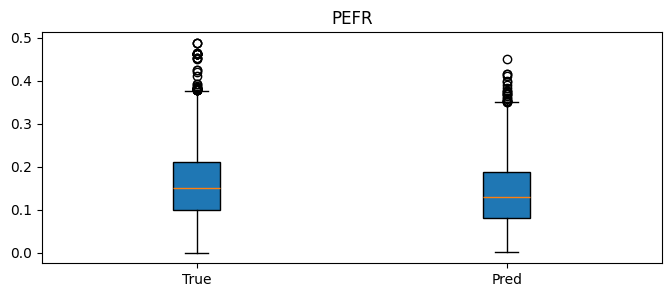

In [7]:
# Flatten the arrays to 1D
PEFR_tbcs_true = PEFR_tbcs_true.ravel()
PEFR_tbcs_pred = PEFR_tbcs_pred.ravel()

plt.figure(figsize=(8, 3))
plt.boxplot([PEFR_tbcs_true, PEFR_tbcs_pred], patch_artist=True)
plt.xticks([1, 2], ['True', 'Pred'])
plt.title('PEFR')
plt.show()